In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

from tqdm import tqdm

/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

full_dataset = torchvision.datasets.CelebA('./files/', download=True,
                                   transform=torchvision.transforms.Compose([
                                 transforms.Resize([64, 64]),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 100000
TEST_SIZE = 10000
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_ds_celeb, test_ds_celeb = torch.utils.data.random_split(full_dataset, [train_size, test_size])


BATCH_SIZE = 32
dl = DataLoader(train_ds_celeb, batch_size=BATCH_SIZE,     num_workers=10)
dl_test = DataLoader(test_ds_celeb, batch_size=BATCH_SIZE, num_workers=10)

#full dataset train
FULL_TRAIN_SIZE = 50000
dl_full = DataLoader(train_ds_celeb, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 10000
dl_full = DataLoader(test_ds_celeb, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

DS_IN_CHANNELS=3

Files already downloaded and verified
torch.Size([50000, 3, 64, 64])
tensor(1.)
(tensor([0, 1]), tensor([1548141,  451859]))


In [5]:
# import torchvision
# from torchvision import transforms
# from torch.utils.data import Subset, Dataset, DataLoader

# train_ds_cifar10 = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                  transforms.Resize(32),
#                                  torchvision.transforms.ToTensor(),
#                              ]))
# test_ds_cifar10  = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                  transforms.Resize(32),
#                                  torchvision.transforms.ToTensor(),
#                              ]))

# # dataset and dataloader
# TRAIN_SIZE = 50000
# TEST_SIZE = 10000
# BATCH_SIZE = 32
# dl = DataLoader(train_ds_cifar10, batch_size=BATCH_SIZE,     num_workers=10)
# dl_test = DataLoader(test_ds_cifar10, batch_size=BATCH_SIZE, num_workers=10)

# #full dataset train
# FULL_TRAIN_SIZE = 50000
# dl_full = DataLoader(train_ds_cifar10, batch_size=FULL_TRAIN_SIZE)
# for x, y in dl_full:
#     X_full_train = x
#     targets = y
#     break

# #full dataset train
# FULL_TEST_SIZE = 10000
# dl_full = DataLoader(test_ds_cifar10, batch_size=FULL_TEST_SIZE)
# for x, y in dl_full:
#     X_full_test = x
#     targets_test = y
#     break

# print(X_full_train.shape, X_full_test.shape)
# print(torch.max(X_full_train))
# print(targets.unique(return_counts=True))

# DS_IN_CHANNELS=3

# Upload model

In [6]:
device = 'cpu' #torch.device(torch.cuda.get_device_name(1))
device = 'cuda:0'

In [7]:
# MODEL_TYPE = 'LRAE'
MODEL_TYPE = 'LRAE'

# Upload the model
model_dir = 'evaluation'
# model_dir = 'test_1_save'
# model_dir = ''

# model_name = 'MNIST__VAE_128__50__10ktrain'
# model_name = 'test1__MNIST__AE__128__0.01'
# model_name = 'test1__MNIST__LRAE__128__0.01__10'






GOOD_MODEL_TYPE = ['VAE', 'AE', 'LRAE']
assert MODEL_TYPE in GOOD_MODEL_TYPE, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"

In [8]:
from models.R1AE_CelebA import ConvLRAE, ConvVAE, ConvAE


In [9]:
# PARAMETERS
IN_FEATURES = 1024*4*4
OUT_FEATURES = 512
N_BINS = 20
GRID = torch.arange(1,N_BINS+1).to(device)/N_BINS

# nonlinearity = 

DROPOUT = 0.0
TEMP = 0.5
SAMPLING = 'gumbell'



In [10]:
if MODEL_TYPE == 'LRAE':
     model = ConvLRAE(IN_FEATURES, OUT_FEATURES, N_BINS, GRID, dropout=DROPOUT, nonlinearity=nn.ReLU(),
                sampling=SAMPLING, temperature=TEMP, in_channels=DS_IN_CHANNELS).to(device)
elif MODEL_TYPE == 'VAE':
    model = ConvVAE(IN_FEATURES, OUT_FEATURES, nonlinearity=nn.ReLU(), in_channels=DS_IN_CHANNELS).to(device)
elif MODEL_TYPE == 'AE':
    model = ConvAE(IN_FEATURES, OUT_FEATURES, nonlinearity=nn.ReLU(), in_channels=DS_IN_CHANNELS).to(device)
else:
    assert False, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"
    
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
print(f"{MODEL_TYPE} was inisialized")

LRAE was inisialized


In [11]:
X_full_test[0].shape

torch.Size([3, 64, 64])

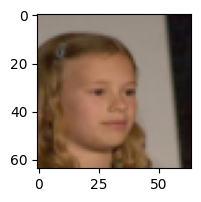

In [12]:

X_full_test.shape
plt.figure(figsize=[2,2])
plt.imshow(X_full_test[49].permute(1, 2, 0))

In [13]:
X_in = torch.rand(X_full_test.shape)[:2].to(device)
X_out = model(X_in)
print(f"{X_in.shape} --> {X_out.shape}")

torch.Size([2, 3, 64, 64]) --> torch.Size([2, 3, 64, 64])


# Training

In [14]:
# setup training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# PATH = PATH
EPOCHS = 50
ALPHA = 0.01

loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
i = 0
loss = 0

In [25]:
######## Training
print("Training of the model")




alpha_kl = ALPHA
alpha_entropy = ALPHA
if MODEL_TYPE == 'LRAE':
    alpha_entropy *= OUT_FEATURES/8
    print(f"Alpha update = {OUT_FEATURES/8: .3f}")
    print(f"Entropy alpha = {alpha_entropy: .3e}")


# epoch_save_backup = EPOCH_SAVE_BACKUP
# show_loss_backup = SHOW_LOSS_BACKUP


# Training
model.train()
optimizer.zero_grad()
torch.cuda.empty_cache()

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
        
    # Training
    model.train() # Model to train
    for x_batch, y_batch in dl:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # model forward
        # 2d downsampling
        x_down = model.down(x_batch)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(x_flat)
        decoded_1d = model.low_rank.decoder(encoded_out_dim)
        
        # 2d upsampling
        decoded_2d_small = decoded_1d.view(B, C, H, W)
        decoded_2d = model.up(decoded_2d_small)
        
        # loss

#         loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        # factors_probability = nn.Softmax(dim=-1)(factors_probability)
        # loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        loss = criterion(decoded_2d.view(-1), x_batch.view(-1)) 
        if MODEL_TYPE == 'VAE':
            loss += alpha_kl*factors_probability.mean()  # KL loss
            
        if MODEL_TYPE == 'LRAE':
            factors_probability = nn.Softmax(dim=-1)(factors_probability)
            loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)            
            loss += alpha_entropy*torch.mean(torch.exp(loss_entropy)) # entropy loss
            
            
          
            
            
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    # model forward
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    x_decoded = model(x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                    
            assert torch.isnan(x_decoded).sum() == 0, f"Error! Nan values ({torch.isnan(x_decoded).sum()}) in models output"
      
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
          
            
    # # backup saving  
    # if epoch%epoch_save_backup == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss,
    #         'loss_list_train': loss_list_train,
    #         'loss_list_test': loss_list_test,
            
    #         }, PATH + f"__{epoch}.pth")
      
    # # loss printing        
    # if (epoch % show_loss_backup == show_loss_backup-1) or (epoch == EPOCHS -1):
    #     fig = plt.figure(figsize=(6,3))
    #     plt.plot(loss_list_train, alpha=0.5, label='train')
    #     plt.plot(loss_list_test, alpha=0.5, label='test')
    #     plt.legend()
    #     plt.savefig( PATH  + "_loss.png")
    #     pass
            
            
        



# print("Finishing of the training...")
# torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#         'loss_list_train': loss_list_train,
#         'loss_list_test': loss_list_test,
        
#         }, PATH + f"__{epoch}__end.pth")

# print("Model training was successfully finished and saved!")

Training of the model
Alpha update =  64.000
Entropy alpha =  6.400e-01


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [07:05<5:47:51, 425.94s/it]


KeyboardInterrupt: 

In [17]:
epoch = -1

In [18]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'loss_list_train': loss_list_train,
            'loss_list_test': loss_list_test,
            
            }, "test_.pth")

In [20]:
import sys
sys. getsizeof(model.state_dict())

1600

In [21]:
1600/8

200.0

# Loading

In [ ]:
# # Upload the model
# model_name = 'test1__MNIST__LRAE__128__0.01__5'
# model_dir = 'test_1_save'
model_path = os.path.join(model_dir, model_name + '.pth')

In [ ]:
## Loading
# PATH = "MNIST__gumbell__entropy__200"
# PATH = "MNIST__VAE__8__25"
PATH = model_path

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loss_list_train = checkpoint['loss_list_train']
loss_list_test = checkpoint['loss_list_test']

# Evaluation

In [ ]:
from models.evaluation import inf_by_layers, check_reconstruction, gen_idx_for_batches, display_datasets
from models.evaluation import gen_gm_dataset, update_FID_class, ManualFID, prepare_to_FID
from torchmetrics.image.fid import FrechetInceptionDistance as tm_FrechetInceptionDistance
from torcheval.metrics import FrechetInceptionDistance

from sklearn.mixture import GaussianMixture